### pre-processing GROMACS output

manually generate necessary pdb topology file from supplied DESRES mae file

### startup

In [1]:
import os
import math
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import mdtraj as md
import nglview as nv
from __future__ import division

In [2]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
# fix random seed for reproducibility
np.random.seed(200184)

### loading simulation trajectory

In [4]:
pdb_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = "/home/maxtopel/Desktop/History/Gaussian Mol Rec/mol rec/Chignolin_partial/CLN2025-0-protein/"
trj_file = []
for i in range(10):
    fname = "CLN025-0-protein-00" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
for i in range(10,54):
    fname = "CLN025-0-protein-0" + str(i) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
    
# loading
traj = md.load(trj_file, top=pdb_file)

# restricting atoms in trajectory
idx_atoms = traj.topology.select_atom_indices('heavy') # 'heavy' OR 'minimal' OR 'all'
traj = traj.atom_slice(idx_atoms)
# rot+trans alignment of trajectory to first frame
traj.center_coordinates(mass_weighted=False)
traj.superpose(traj[0])

#npzfile = np.load('../../Chignolin_partial/princMom.npz')
#sorted(npzfile.files)
#princMom = npzfile['princMom']
#Rg = npzfile['Rg']



<mdtraj.Trajectory with 534743 frames, 93 atoms, 10 residues, and unitcells at 0x7fd9ff5f50d0>

In [5]:
# loading
traj = md.load(trj_file, top=pdb_file)

In [6]:
# rot+trans alignment of trajectory to first frame
traj.center_coordinates(mass_weighted=False)
traj.superpose(traj[0])

<mdtraj.Trajectory with 534743 frames, 166 atoms, 10 residues, and unitcells at 0x7fd9bf427990>

In [7]:
print('How many frames? %s' % traj.n_frames)
print('How many atoms?    %s' % traj.n_atoms)
print(traj.xyz.shape)

How many frames? 534743
How many atoms?    166
(534743, 166, 3)


### constructing atom restricted trajectory

In [8]:
idx_atoms = traj.topology.select_atom_indices('heavy') # 'heavy' OR 'minimal' OR 'all'

In [9]:
traj_restricted = deepcopy(traj)
traj_restricted = traj_restricted.atom_slice(idx_atoms)

In [10]:
print('How many frames? %s' % traj_restricted.n_frames)
print('How many atoms?    %s' % traj_restricted.n_atoms)
print(traj_restricted.xyz.shape)

How many frames? 534743
How many atoms?    93
(534743, 93, 3)


In [11]:
h2t = md.compute_distances(traj,[[0, traj.n_atoms-1]],periodic=False,opt=True)print

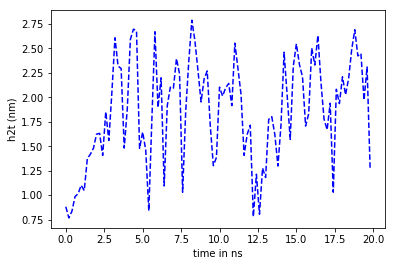

In [12]:
# plotting h2t
fig, ax = plt.subplots()
ax.plot(np.multiply(np.arange(h2t.shape[0])[0:100],np.array(0.2)), h2t[0:100], 'b--')
ax.set_xlabel("time in ns")
ax.set_ylabel("h2t (nm)")
plt.draw()
plt.show()
fig.savefig('h2t.png', dpi=300)
plt.close()

In [13]:
# saving
np.savez('h2t.npz', h2t=h2t)

In [14]:
#DONE

bin_sizes=[1,2,3,4,5,10,15,20,25,50] 

for i in bin_sizes:
    h2t_train = []
    for j in range(len(h2t)-i):
        h2t_train.append(np.mean(h2t[j:j+i]))# [j*i:(j+1)*i]))
    np.savez('h2t_%fns.npz' %(i*0.2),h2t_train = h2t_train)

In [15]:
 a=[1,2]
print(range(1))

[0]


In [20]:
# need to do the same thing with the atomic trajectories:
#### WITH EXTENSION

### COMP MOD


from copy import deepcopy
bin_sizes=[1,2,3,4,5,10,15,20,25,50] 
c = 3
b = len(traj_restricted.xyz[1])

#for every bin size
for i in bin_sizes:
    a = int(np.floor(len(traj_restricted)/(i*10))*i*10)
    print(a)    # initialize trajectory
    trjp = deepcopy(traj_restricted)
    print(len(trjp))
    
    
    
    for j in range(1):
        #for every heavy atom
        trjp_j = []
        for k in range(b):
            # for every atomic coordinate:
            trjp_j_k = []
            trjpp = deepcopy(traj_restricted.xyz[j:j+i])
            for l in range(c):
                #compute mean atomic coordinate:
                #print(len(trjpp))
                sm = 0
                #iterate over every time element in trjpp
                for m in range(len(trjpp)):
                    sm += trjpp[m][k][l]
                # compute mean coordinate
                sm /=len(trjpp)
                #add mean coordinate to list of coordinates
                trjp_j_k.append(sm) # np.mean(traj.xyz[j*i:(j+1)*i][k][l])
            #print(trjp_j_k)
        
            #delivers [x,y,z] for atom k, appends to list of atomic coordinates for trjp at bin range j
            trjp_j.append(trjp_j_k)
        #delivers a list of the atomic coordinates of each of the heavy atoms for trjp in bin range j
        #print(j)
        trjp.xyz[j]=trjp_j
    
    ###################################################
    #This gives us our first data point
    #Now we add the new marginal frame and subtract the oldest marginal frame effects    
    
    #for every bin we want to compute
    for j in range(1,a-i):
        
        #initialize the frame to be integrated, define the frame to be deleated and call the last averaged frame for modification
        trjp_up = deepcopy(traj_restricted.xyz[j+i-1])
        trjp_down = deepcopy(traj_restricted.xyz[j-1])
        trjpp = deepcopy(trjp.xyz[j-1])
        #for every heavy atom
        for k in range(b):
            # for every atomic coordinate:
            for l in range(c):
                #add info from new frame
                trjpp[k][l] += trjp_up[k][l]/i
                #delete info from new frame
                trjpp[k][l] -= trjp_down[k][l]/i
        #save new frame
        trjp.xyz[j]=trjpp
        
        if np.mod(j,10000) == 0:
            print('frame no %f/%f completed' %(j,a-i)  )
    trjp_init = trjp[0]
    #save data
    #trjp_init.save_pdb('trj_train_init%dns.pdb' %(i*0.2))
    trjp_init.save_pdb('trj_init%fns.pdb' %(i*0.2))
    #save data
    #trjp.save_pdb('trj_train_%dns.pdb' %(i*0.2))
    trjp.save_xtc('trj_%fns.xtc' %(i*0.2))
    
    #np.savez('trj_%dns.pdb' %(i*0.2),trjp = trjp)
    print('time %f complete' %(i*0.2))
    #trjp = md.load(trj_file, top=pdb_file)
    #trjp = np.array
    
    princMom = []
    for frame in range(trjp.n_frames):

        xyz = trjp.xyz[frame]

        gt = np.zeros((3,3),dtype=float)
        for ii in range(xyz.shape[0]):
            gt += np.outer(xyz[ii,:],xyz[ii,:])
        gt /= xyz.shape[0]

        lambdas = np.flip( np.linalg.eigvalsh(gt) )

        princMom.append(lambdas)

        if np.mod(frame+1,10000) == 0:
            print('\tProcessed %f of %f frames...' % (frame+1,trjp.n_frames))

    princMom = np.array(princMom)
                  
    Rg = np.sqrt( np.sum( princMom**2, axis=1) )
    np.savez('princMom_%fns.npz' %(i*0.2), princMom=princMom, Rg=Rg)
    print('Bin Size %fns complete' %(i*0.2))



534740
534743
frame no 10000.000000/534739.000000 completed
frame no 20000.000000/534739.000000 completed
frame no 30000.000000/534739.000000 completed
frame no 40000.000000/534739.000000 completed
frame no 50000.000000/534739.000000 completed
frame no 60000.000000/534739.000000 completed
frame no 70000.000000/534739.000000 completed
frame no 80000.000000/534739.000000 completed
frame no 90000.000000/534739.000000 completed
frame no 100000.000000/534739.000000 completed
frame no 110000.000000/534739.000000 completed
frame no 120000.000000/534739.000000 completed
frame no 130000.000000/534739.000000 completed
frame no 140000.000000/534739.000000 completed
frame no 150000.000000/534739.000000 completed
frame no 160000.000000/534739.000000 completed
frame no 170000.000000/534739.000000 completed
frame no 180000.000000/534739.000000 completed
frame no 190000.000000/534739.000000 completed
frame no 200000.000000/534739.000000 completed
frame no 210000.000000/534739.000000 completed
frame no

	Processed 90000.000000 of 534743.000000 frames...
	Processed 100000.000000 of 534743.000000 frames...
	Processed 110000.000000 of 534743.000000 frames...
	Processed 120000.000000 of 534743.000000 frames...
	Processed 130000.000000 of 534743.000000 frames...
	Processed 140000.000000 of 534743.000000 frames...
	Processed 150000.000000 of 534743.000000 frames...
	Processed 160000.000000 of 534743.000000 frames...
	Processed 170000.000000 of 534743.000000 frames...
	Processed 180000.000000 of 534743.000000 frames...
	Processed 190000.000000 of 534743.000000 frames...
	Processed 200000.000000 of 534743.000000 frames...
	Processed 210000.000000 of 534743.000000 frames...
	Processed 220000.000000 of 534743.000000 frames...
	Processed 230000.000000 of 534743.000000 frames...
	Processed 240000.000000 of 534743.000000 frames...
	Processed 250000.000000 of 534743.000000 frames...
	Processed 260000.000000 of 534743.000000 frames...
	Processed 270000.000000 of 534743.000000 frames...
	Processed 28

frame no 130000.000000/534716.000000 completed
frame no 140000.000000/534716.000000 completed
frame no 150000.000000/534716.000000 completed
frame no 160000.000000/534716.000000 completed
frame no 170000.000000/534716.000000 completed
frame no 180000.000000/534716.000000 completed
frame no 190000.000000/534716.000000 completed
frame no 200000.000000/534716.000000 completed
frame no 210000.000000/534716.000000 completed
frame no 220000.000000/534716.000000 completed
frame no 230000.000000/534716.000000 completed
frame no 240000.000000/534716.000000 completed
frame no 250000.000000/534716.000000 completed
frame no 260000.000000/534716.000000 completed
frame no 270000.000000/534716.000000 completed
frame no 280000.000000/534716.000000 completed
frame no 290000.000000/534716.000000 completed
frame no 300000.000000/534716.000000 completed
frame no 310000.000000/534716.000000 completed
frame no 320000.000000/534716.000000 completed
frame no 330000.000000/534716.000000 completed
frame no 3400

	Processed 200000.000000 of 534743.000000 frames...
	Processed 210000.000000 of 534743.000000 frames...
	Processed 220000.000000 of 534743.000000 frames...
	Processed 230000.000000 of 534743.000000 frames...
	Processed 240000.000000 of 534743.000000 frames...
	Processed 250000.000000 of 534743.000000 frames...
	Processed 260000.000000 of 534743.000000 frames...
	Processed 270000.000000 of 534743.000000 frames...
	Processed 280000.000000 of 534743.000000 frames...
	Processed 290000.000000 of 534743.000000 frames...
	Processed 300000.000000 of 534743.000000 frames...
	Processed 310000.000000 of 534743.000000 frames...
	Processed 320000.000000 of 534743.000000 frames...
	Processed 330000.000000 of 534743.000000 frames...
	Processed 340000.000000 of 534743.000000 frames...
	Processed 350000.000000 of 534743.000000 frames...
	Processed 360000.000000 of 534743.000000 frames...
	Processed 370000.000000 of 534743.000000 frames...
	Processed 380000.000000 of 534743.000000 frames...
	Processed 3

frame no 250000.000000/534585.000000 completed
frame no 260000.000000/534585.000000 completed
frame no 270000.000000/534585.000000 completed
frame no 280000.000000/534585.000000 completed
frame no 290000.000000/534585.000000 completed
frame no 300000.000000/534585.000000 completed
frame no 310000.000000/534585.000000 completed
frame no 320000.000000/534585.000000 completed
frame no 330000.000000/534585.000000 completed
frame no 340000.000000/534585.000000 completed
frame no 350000.000000/534585.000000 completed
frame no 360000.000000/534585.000000 completed
frame no 370000.000000/534585.000000 completed
frame no 380000.000000/534585.000000 completed
frame no 390000.000000/534585.000000 completed
frame no 400000.000000/534585.000000 completed
frame no 410000.000000/534585.000000 completed
frame no 420000.000000/534585.000000 completed
frame no 430000.000000/534585.000000 completed
frame no 440000.000000/534585.000000 completed
frame no 450000.000000/534585.000000 completed
frame no 4600

	Processed 310000.000000 of 534743.000000 frames...
	Processed 320000.000000 of 534743.000000 frames...
	Processed 330000.000000 of 534743.000000 frames...
	Processed 340000.000000 of 534743.000000 frames...
	Processed 350000.000000 of 534743.000000 frames...
	Processed 360000.000000 of 534743.000000 frames...
	Processed 370000.000000 of 534743.000000 frames...
	Processed 380000.000000 of 534743.000000 frames...
	Processed 390000.000000 of 534743.000000 frames...
	Processed 400000.000000 of 534743.000000 frames...
	Processed 410000.000000 of 534743.000000 frames...
	Processed 420000.000000 of 534743.000000 frames...
	Processed 430000.000000 of 534743.000000 frames...
	Processed 440000.000000 of 534743.000000 frames...
	Processed 450000.000000 of 534743.000000 frames...
	Processed 460000.000000 of 534743.000000 frames...
	Processed 470000.000000 of 534743.000000 frames...
	Processed 480000.000000 of 534743.000000 frames...
	Processed 490000.000000 of 534743.000000 frames...
	Processed 5

frame no 370000.000000/534450.000000 completed
frame no 380000.000000/534450.000000 completed
frame no 390000.000000/534450.000000 completed
frame no 400000.000000/534450.000000 completed
frame no 410000.000000/534450.000000 completed
frame no 420000.000000/534450.000000 completed
frame no 430000.000000/534450.000000 completed
frame no 440000.000000/534450.000000 completed
frame no 450000.000000/534450.000000 completed
frame no 460000.000000/534450.000000 completed
frame no 470000.000000/534450.000000 completed
frame no 480000.000000/534450.000000 completed
frame no 490000.000000/534450.000000 completed
frame no 500000.000000/534450.000000 completed
frame no 510000.000000/534450.000000 completed
frame no 520000.000000/534450.000000 completed
frame no 530000.000000/534450.000000 completed
time 10.000000 complete
	Processed 10000.000000 of 534743.000000 frames...
	Processed 20000.000000 of 534743.000000 frames...
	Processed 30000.000000 of 534743.000000 frames...
	Processed 40000.000000 

# need to do the same thing with the atomic trajectories:
#### WITH EXTENSION


from copy import deepcopy
bin_sizes=[5,250,500] #1,10,25,50,100,

c = 3

#for every bin size
for i in bin_sizes:
    a = int(np.floor(len(traj_restricted)/(i*10))*i*10)
    print(a)
    b = len(traj_restricted.xyz[1])
    print(b)
    # initialize trajectory
    trjp = deepcopy(traj_restricted)
    print(len(trjp))
    #for every bin
    for j in range(a-i):
        #for every heavy atom
        trjp_j = []
        for k in range(b):
            # for every atomic coordinate:
            trjp_j_k = []
            trjpp = deepcopy(traj_restricted.xyz[j:j+i])
            for l in range(c):
                #compute mean atomic coordinate:
                #print(len(trjpp))
                sm = 0
                #iterate over every time element in trjpp
                for m in range(len(trjpp)):
                    sm += trjpp[m][k][l]
                # compute mean coordinate
                sm /=len(trjpp)
                #add mean coordinate to list of coordinates
                trjp_j_k.append(sm) # np.mean(traj.xyz[j*i:(j+1)*i][k][l])
            #print(trjp_j_k)
        
            #delivers [x,y,z] for atom k, appends to list of atomic coordinates for trjp at bin range j
            trjp_j.append(trjp_j_k)
        #delivers a list of the atomic coordinates of each of the heavy atoms for trjp in bin range j
        #print(j)
        trjp.xyz[j]=trjp_j
    trjp_init = trjp[0]
    #save data
    #trjp_init.save_pdb('trj_train_init%dns.pdb' %(i*0.2))
    trjp_init.save_pdb('trj_init%dns.pdb' %(i*0.2))
    #save data
    #trjp.save_pdb('trj_train_%dns.pdb' %(i*0.2))
    trjp.save_xtc('trj_%dns.xtc' %(i*0.2))
    
    #np.savez('trj_%dns.pdb' %(i*0.2),trjp = trjp)
    print('time %d complete' %(i*0.2))
    #trjp = md.load(trj_file, top=pdb_file)
    #trjp = np.array
    
    princMom = []
    for frame in range(trjp.n_frames):

        xyz = trjp.xyz[frame]

        gt = np.zeros((3,3),dtype=float)
        for ii in range(xyz.shape[0]):
            gt += np.outer(xyz[ii,:],xyz[ii,:])
        gt /= xyz.shape[0]

        lambdas = np.flip( np.linalg.eigvalsh(gt) )

        princMom.append(lambdas)

        if np.mod(frame+1,10000) == 0:
            print('\tProcessed %d of %d frames...' % (frame+1,trjp.n_frames))

    princMom = np.array(princMom)
                  
    Rg = np.sqrt( np.sum( princMom**2, axis=1) )
    np.savez('princMom_%dns.npz' %(i*0.2), princMom=princMom, Rg=Rg)
    print('Bin Size %dns complete' %(i*0.2))

ONLY RUN IF MEAN UNKOWN

In [17]:
from copy import deepcopy
mid = np.mean(h2t)
indyx = []
for i in range(len(h2t)):
    if mid*0.85< h2t[i] < mid*1.15:
        indyx.append(i)
        
trjp = deepcopy(traj_restricted.xyz)
trj_ref = deepcopy(trjp)
trj_ref = trj_ref[::1000]
print(len(trj_ref))

min_rmsd = 10000000000
min_indyx = 0
#traj_indyx = traj[indyx]
RMSD_i_list = []

ct = 0
RMSD_indyx = []
for i in indyx:
    RMSD_i = 0 
    for j in range(len(trj_ref)):
        RMSD_i += (np.sqrt(np.mean((trjp[i] - trj_ref[j])**2)))# md.rmsd(traj.xyz[i],traj[j])
        #print(RMSD_i)
    RMSD_i_list.append(RMSD_i)
    RMSD_indyx.append(i)
    ct +=1
    if np.mod(ct,10000) == 0:
        print(ct)
    #print(RMSD_i)
    #if RMSD_i < min_rmsd:
     #   min_rmsd = RMSD_i
      #  min_indyx= i      
    
    
RMSDS = np.zeros([2,len(RMSD_i_list)])
for i in range(len(RMSD_i_list)):
    RMSDS[0,i] = RMSD_i_list[i]
    RMSDS[1,i] = RMSD_indyx[i]
    
RMSDS.sort()

min_rmsd = 10000000000
min_indyx = 0
#traj_indyx = traj[indyx]
RMSD_final = np.zeros([500,2])

#ct = 0
RMSD_indyx = []
for i in range(500):
    RMSD_i = 0 
    for j in range(len(trjp)):
        RMSD_i += (np.sqrt(np.mean((trjp[int(RMSDS[1,i])] - trjp[j])**2)))# md.rmsd(traj.xyz[i],traj[j])
        #print(RMSD_i)
    RMSD_final[i,0] = RMSD_i
    RMSD_final[i,1] = i
    #print(i)
    #if np.mod(ct,1) == 0:
    
    #print(RMSD_i)
    #if RMSD_i < min_rmsd:
     #   min_rmsd = RMSD_i
      #  min_indyx= i
        
np.savez('RMSD_list.npz', RMSD_final=RMSD_final,RMSDS=RMSDS)        
min_rmsd = min(RMSD_final[:,0])
print(min_rmsd, min_rmsd/len(trjp))

mincp = list(deepcopy(RMSD_final[:,0]))
mincp_ind = mincp.index(min(mincp))
print(mincp_ind)


min_indyx = int(RMSDS[1,mincp_ind])
minv = h2t[min_indyx]
rmsd = min_rmsd/len(trjp)
print(rmsd)
print(h2t[min_indyx],mid*0.85,mid*1.15)

np.savez('mean_h2t_indyx.npz', min_indyx=min_indyx, minv=minv,rmsd=rmsd)

535
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
(83152.6186950244, 0.1555001537093976)
488
0.1555001537093976
(array([0.9619665], dtype=float32), 0.8815388143062591, 1.1926701605319976)


In [18]:
trjp = deepcopy(traj_restricted.xyz)
RMSD_i = 0
for j in range(len(trjp)):
        RMSD_i += (np.sqrt(np.mean((trjp[min_indyx] - trjp[j])**2)))# md.rmsd(traj.xyz[i],traj[j])
print(RMSD_i,RMSD_i/len(trjp))


(83152.6186950244, 0.1555001537093976)


In [19]:
rte =2*1e67*40*2e-23*3*1e-4
print(rte)
r = 2.52347e+22
surf = 4*np.pi*r**2
print(surf)
print(rte/surf)

4.8e+42
8.00214020022e+45
0.000599839527914


# computing principal moments of gyration tensor for each frame

print('Computing principal moments of gyration tensor...')

princMom = []

for frame in range(traj.n_frames):

    xyz = traj.xyz[frame]

    gt = np.zeros((3,3),dtype=float)
    for i in range(xyz.shape[0]):
        gt += np.outer(xyz[i,:],xyz[i,:])
    gt /= xyz.shape[0]

    lambdas = np.flip( np.linalg.eigvalsh(gt) )
    
    princMom.append(lambdas)
    
    if np.mod(frame+1,10000) == 0:
        print('\tProcessed %d of %d frames...' % (frame+1,traj.n_frames))

princMom = np.array(princMom)
Rg = np.sqrt( np.sum( princMom**2, axis=1) )

print('DONE!')
print('')

# saving
np.savez('princMom.npz', princMom=princMom, Rg=Rg)

from copy import deepcopy
bin_sizes=[5] #,10,25,50,100,250,500
for b in bin_sizes:
    princMom = []
    for frame in range(trjp.n_frames):

        xyz = trjp.xyz[frame]

        gt = np.zeros((3,3),dtype=float)
        for i in range(xyz.shape[0]):
            gt += np.outer(xyz[i,:],xyz[i,:])
        gt /= xyz.shape[0]

        lambdas = np.flip( np.linalg.eigvalsh(gt) )

        princMom.append(lambdas)

        if np.mod(frame+1,10000) == 0:
            print('\tProcessed %d of %d frames...' % (frame+1,trjp.n_frames))

    princMom = np.array(princMom)
                  
    Rg = np.sqrt( np.sum( princMom**2, axis=1) )
    np.savez('princMom_%dns.npz' %(b*0.2), princMom=princMom, Rg=Rg)
    print('Bin Size %dns complete' %(b*0.2))